In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier



PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20% of predictions
ITERATIONS = 100  # Bootstrap iterations
COLORS = ['#323694', '#039573', '#feea2a'] # Color palette for the classifiers


# CMIM ranking of features 
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']


## `EssentiallyClassifier` Class

The `EssentiallyClassifier` class is an abstract base class designed to be implemented by diffent classifiers algorithms provviding a common interface for all classifiers.

In [11]:

class EssentiallyClassifier:
    """
    Abstract class for the essentiality classifier.
    Contains the main methods to load the data, find the optimal number of features and plot the results.
    """

    def __init__(self, file_path, cmim_ranking, percentiles,name, skip_discretization=False):
        self.name = name # Name of classifier
        self.file_path = file_path # Path to the excel file
        self.cmim_ranking = cmim_ranking # CMIM ranking of features 
        self.percentiles = percentiles # Top percentiles 
        self.X = None # Features
        self.y = None # Labels of Grand truth
        self.optimal_features = None # Optimal number of features to use
        self.highest_ppv_5 = 0 # Highest PPV (5%), used to find optimal number of features 
        self.final_ppv_scores = [] # Final PPV scores for the top percentiles
        self.categories = None # Number of unique categories in the data
        self.skip_discretization = skip_discretization # Load the data without discretization


    def load_data(self):
        """
        Loads the data with the specified method.
        """
        self.load_discretized_data() if not self.skip_discretization else self.load_raw_data()


    def load_raw_data(self):
        """
        Loads the data without discretization.
        """
        data = pd.read_excel(self.file_path)
        self.X = data.drop(columns=['Essential', 'orf_id'])
        self.y = data['Essential']

        print("Row data loaded successfully, shape:", self.X.shape, self.y.shape)
        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)
        print("Data saved successfully");

    def load_discretized_data(self):
        """
        Loads and processes discretized data from an Excel file.
        Reads data and uses a label encoder to convert symbols to integers.
        Counts the number of unique categories in the data.
        """
        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

        # Count the number of unique categories in the data
        min_categories = self.X.nunique()
        self.categories = min_categories  

        print("Discretized data loaded successfully, shape:", self.X.shape, self.y.shape)
        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)
        print("Data saved successfully")



    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        """
        Calculate the positive predictive value (PPV) for the top percentiles of predictions.

        Parameters:
            - probabilities: Array of predicted probabilities.
            - true_labels: Grand truth labels.
        
        Returns:
        - PPV values for each specified percentile in self.percentiles.
        """

        if len(probabilities) != len(true_labels):
            raise ValueError("Length of probabilities and true labels must be the same.")

        sorted_indices = np.argsort(probabilities)[::-1] # Sort probabilities in descending order so that the top probabilities are first
        sorted_labels = true_labels[sorted_indices] # Sort true labels according to the sorted probabilities
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100)) # Calc the number of top predictions to consider
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                # def: PPV = TP / (TP + FP)
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles


    def find_optimal_features(self):
        """
        Find the optimal number of features to use by evaluating the classifier with different number 
        of features taken ordered by CMIM ranking.
        """

        # Only features of the specific feature set 
        X_ranked = self.X[self.cmim_ranking]

        print("Starting to find optimal number of features...")

        # Iterate over all the features in the specific CMIM ranking
        for i in range(len(self.cmim_ranking), 0, -1):
            X_selected = X_ranked.iloc[:, :i]

            # Evaluate the model with the selected features
            ppv = self.evaluate_model(X_selected)
            
            ppv_1 = ppv[0] # PPV (1%)
            ppv_5 = ppv[1] # PPV (5%)
            print(f"Features: {i}, PPV (1%): {ppv_1}, PPV (5%): {ppv_5}")

            # Update the highest PPV (1%) and optimal number of features
            if ppv_5 > self.highest_ppv_5 and ppv_1 > ppv_5:
                self.highest_ppv_5 = ppv_5
                self.optimal_features = i


        # Print the results
        print("Highest PPV (5%):", self.highest_ppv_5)
        print("Optimal number of features:", self.optimal_features, self.cmim_ranking[:self.optimal_features])



    def evaluate_final_model(self):
        """
        Evaluate the final model with the optimal number of features.
        """

        if self.optimal_features is None:
            raise ValueError("Optimal number of features to use has not been found.") 

        # Use the optimal number of features found empirically
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]


        # Evaluate the model with the optimal number of features
        self.final_ppv_scores = self.evaluate_model(X_optimal)
    
        print("Final PPV Percentiles:", self.final_ppv_scores)
        
        return self.final_ppv_scores



    def plot_ppv_results(self, ppv):
        """
        Plot the PPV results for the final model and compare with random predictions.

        Parameters:
            - ppv: Array of PPV values for the top percentiles of predictions of the classifier.
        """

        fig, ax = plt.subplots(figsize=(6, 4))
        percentiles_labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        bar_with = 0.2

        ax.bar(np.arange(len(self.percentiles)) - bar_with / 2, ppv, bar_with, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + bar_with / 2, random_ppv, bar_with, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(percentiles_labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()



    def run(self):
        """
        Build, optimize and evaluate the classifier.
        """

        self.load_data()
        self.find_optimal_features() 
        #self.optimal_features = 4
        ppvs = self.evaluate_final_model()
        self.plot_ppv_results(ppvs)



    def evaluate_model(self, X_selected):
        """
        Evaluate the model with the selected features and calculate the PPV for the top percentiles of predictions.

        Parameters:
        - X_selected: Selected features to use for the model.
        
        Returns:
        - PPV values for the top percentiles of predictions.

        To be implemented by the subclass.
        """
        pass


## `EssentiallyBayesClassifier` Class

The `EssentiallyBayesClassifier` class is a specialized implementation of the `EssentiallyClassifier` abstract base class. It utilizes a Naive Bayes classifier to perform essentiality prediction tasks. 
The implementation uses the boostrapping technique.


In [12]:
class EssentiallyBayesClassifier(EssentiallyClassifier):
    """
    Naive Bayes classifier for the essentiality prediction.
    """

    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles ,name)


    def calcolate_boostrap_iteration(self, X_selected):
        """
        Helper function to calculate the single bootstrap iteration for the Naive Bayes classifier.

        Parameters:
            - X_selected: Selected features to use.

        Returns:
            - PPV values for the top percentiles of predictions.
        """


        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        selected_categories = self.categories[X_selected.columns].to_numpy()
   
        
        nb_classifier = CategoricalNB(min_categories=selected_categories)
        nb_classifier.fit(X_train, y_train)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())

   
    # Override 
    def evaluate_model(self, X_selected):
        all_ppvs = []
        for _ in range(ITERATIONS):  # Bootstrap iterations
            ppv_iteration = self.calcolate_boostrap_iteration(X_selected)
            all_ppvs.append(ppv_iteration)

        # Calculate the mean PPV for each percentile over all iterations
        final_ppv = np.mean(all_ppvs, axis=0)
        return final_ppv

## `EssentialityExperiment` Class

The `EssentialityExperiment` class is designed to manage and run and compare multiple classifiers.
It inclueds methods for executing experiments, visualizing omparative tables and plots.


In [13]:
class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name # Name of the experiment
        self.classifiers = classifiers # Classifiers to run and compare

    def run_experiment(self):
        """
        Runs all the classifiers and evaluates their performance.
        """

        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
    
    def plot_and_save_comparative_results(self, percentiles, colors=None):
        """
        Plot the comparative results of the classifiers.
        """

        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors # get default color map if not specified

        fig, ax = plt.subplots(figsize=(6, 4))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        bar_width = 0.1
        gap = 0.03  # Gap between bars in the same group

        # Plot the PPV scores for each classifier
        for idx, classifier in enumerate(self.classifiers):
            ax.bar(x + idx * (bar_width + gap), 
                np.array(classifier.final_ppv_scores) * 100,  
                bar_width, 
                label=classifier.name, 
                color=colors[idx % len(colors)],
                edgecolor='black', 
                linewidth=0.4)  

        # Random predictions
        random_ppv = [np.mean(self.classifiers[0].y) * 100] * len(percentiles)
        ax.bar(x + (len(self.classifiers)) * (bar_width + gap), 
            random_ppv, 
            bar_width, 
            label='Random', 
            color='black', 
            edgecolor='black', 
            linewidth=0.5)

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + (len(self.classifiers) / 2) * (bar_width + gap) )
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 100) 
        ax.legend()
        fig.tight_layout()
        plt.show()

        # Save the plot to a file
        fig.savefig(f'./output/{self.name}_ppv_plot.png')


    def plot_and_save_comparative_table(self):
        """
        Plot a comparative table of the final PPV scores for each classifier.
        """
 
        rows = []
        for classifier in self.classifiers:
            if len(classifier.final_ppv_scores) != len(PERCENTILES):
                raise ValueError(
                    f"Inconsistent length for classifier '{classifier.name}': "
                    f"expected {len(PERCENTILES)} scores, got {len(classifier.final_ppv_scores)}."
                )
            rounded_scores = [str(round(score, 2)) for score in classifier.final_ppv_scores]
            rows.append(
                [classifier.name] + rounded_scores + [classifier.optimal_features]
            )

        # Create DataFrame
        columns = ['Classifier'] + [f'{p}%' for p in PERCENTILES] + ['Number of Features']
        table_df = pd.DataFrame(rows, columns=columns)
        table_df.set_index('Classifier', inplace=True)

        # Define a color palette for each row
        colors = [f'{color}50' for color in COLORS]  # Add alpha chanel to colors
        color_map = {classifier.name: colors[i % len(colors)] for i, classifier in enumerate(self.classifiers)}

     
        def highlight_row(row):
            classifier = row.name
            color = color_map.get(classifier, '#FFFFFF')  
            return [f'background-color: {color};'] * len(row)

        styled_df = table_df.style.apply(highlight_row, axis=1)


        styled_df = styled_df.set_table_attributes('style="font-size: 14px; border-collapse: collapse;"')


        # Save the table to a CSV file
        table_df.to_csv(f'./output/{self.name}_ppv_table.csv')


        return styled_df


Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9243478260869571, PPV (5%): 0.7580508474576271
Features: 41, PPV (1%): 0.9134782608695654, PPV (5%): 0.756949152542373
Features: 40, PPV (1%): 0.9139130434782611, PPV (5%): 0.750593220338983
Features: 39, PPV (1%): 0.9156521739130438, PPV (5%): 0.7527966101694916
Features: 38, PPV (1%): 0.9134782608695653, PPV (5%): 0.761864406779661
Features: 37, PPV (1%): 0.9195652173913044, PPV (5%): 0.7546610169491523
Features: 36, PPV (1%): 0.91304347826087, PPV (5%): 0.7591525423728814
Features: 35, PPV (1%): 0.9182608695652175, PPV (5%): 0.7620338983050846
Features: 34, PPV (1%): 0.917826086956522, PPV (5%): 0.7529661016949154
Features: 33, PPV (1%): 0.9160869565217398, PPV (5%): 0.7590677966101699
Features: 32, PPV (1%): 0.9208695652173917, PPV (5%): 0.7561864406779661
Features: 31, PPV (1%): 0.9173913043478267, PPV (5%): 0.769237288135

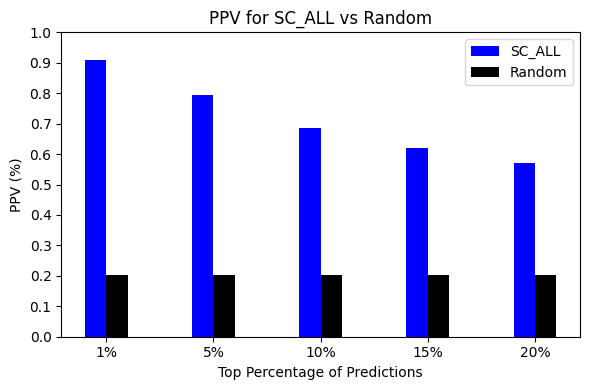

In [14]:
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')
classifier_all.run()



--------------------------------------------------------------------------------
Running experiment for S. cerevisiae
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.910434782608696, PPV (5%): 0.7577966101694917
Features: 41, PPV (1%): 0.9130434782608698, PPV (5%): 0.7621186440677967
Features: 40, PPV (1%): 0.9191304347826089, PPV (5%): 0.7645762711864407
Features: 39, PPV (1%): 0.9134782608695656, PPV (5%): 0.7591525423728812
Features: 38, PPV (1%): 0.9178260869565221, PPV (5%): 0.7575423728813558
Features: 37, PPV (1%): 0.9147826086956526, PPV (5%): 0.755
Features: 36, PPV (1%): 0.9091304347826085, PPV (5%): 0.7565254237288134
Features: 35, PPV (1%): 0.9130434782

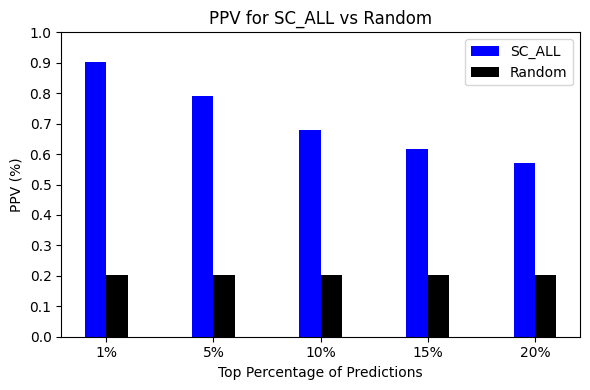

Running classifier SC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.8073913043478259, PPV (5%): 0.6599152542372881
Features: 15, PPV (1%): 0.8086956521739127, PPV (5%): 0.6738135593220338
Features: 14, PPV (1%): 0.8139130434782607, PPV (5%): 0.6688983050847456
Features: 13, PPV (1%): 0.8226086956521734, PPV (5%): 0.6780508474576271
Features: 12, PPV (1%): 0.8299999999999992, PPV (5%): 0.6977118644067797
Features: 11, PPV (1%): 0.8491304347826083, PPV (5%): 0.7216101694915256
Features: 10, PPV (1%): 0.8417391304347821, PPV (5%): 0.7223728813559321
Features: 9, PPV (1%): 0.8673913043478252, PPV (5%): 0.7047457627118644
Features: 8, PPV (1%): 0.8560869565217389, PPV (5%): 0.7019491525423731
Features: 7, PPV (1%): 0.8213043478260867, PPV (5%): 0.6882203389830505
Features: 6, PPV (1%): 0.8208695652173913, PPV (5%): 0.68

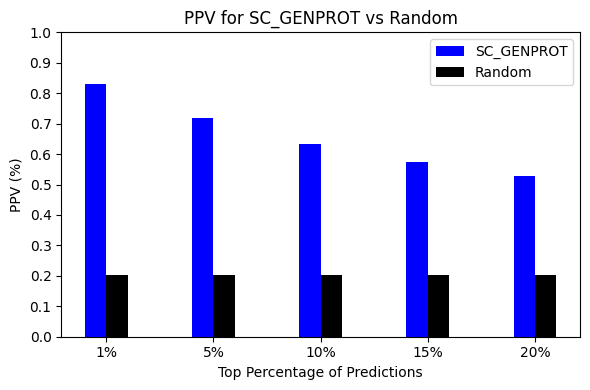

Running classifier SC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.657826086956522, PPV (5%): 0.5181355932203391
Features: 14, PPV (1%): 0.6030434782608699, PPV (5%): 0.5177966101694913
Features: 13, PPV (1%): 0.6204347826086959, PPV (5%): 0.5280508474576274
Features: 12, PPV (1%): 0.5682608695652176, PPV (5%): 0.4506779661016948
Features: 11, PPV (1%): 0.5495652173913046, PPV (5%): 0.458050847457627
Features: 10, PPV (1%): 0.5226086956521742, PPV (5%): 0.4592372881355933
Features: 9, PPV (1%): 0.452173913043478, PPV (5%): 0.4952542372881355
Features: 8, PPV (1%): 0.463478260869565, PPV (5%): 0.5039830508474575
Features: 7, PPV (1%): 0.513913043478261, PPV (5%): 0.5288135593220339
Features: 6, PPV (1%): 0.5213043478260869, PPV (5%): 0.538220338983051
Features: 5, PPV (1%): 0.5230434782608697, PPV (5%): 0.544661

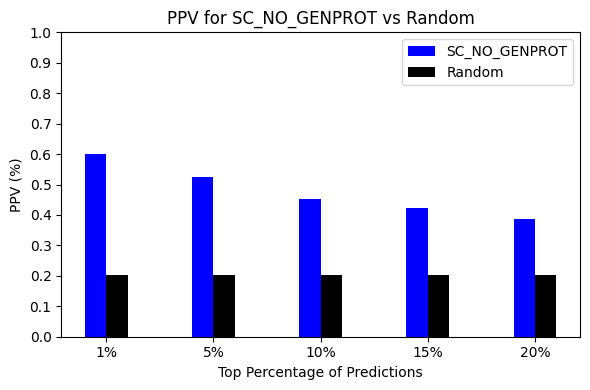

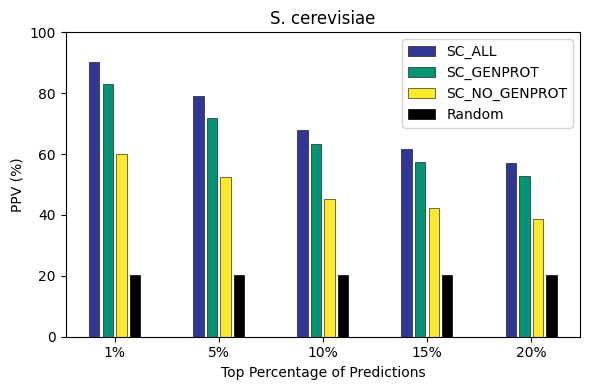

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.9,0.79,0.68,0.62,0.57,22
SC_GENPROT,0.83,0.72,0.63,0.58,0.53,10
SC_NO_GENPROT,0.6,0.53,0.45,0.42,0.39,13


In [15]:


classifier_no_genprot = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae", [classifier_all, classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS)
experiment.plot_and_save_comparative_table()



In [16]:
class EssentialityRandomForestClassifier(EssentiallyClassifier):
    """
    Random Forest classifier for the essentiality prediction.
    """


    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles,name, skip_discretization=True)

   
    # Override
    def evaluate_model(self, X_selected):

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        # Build the Random Forest classifier
        rf_classifier = RandomForestClassifier(
        n_estimators=300,           # Number of trees (default=100)
        max_depth=20,               # Maximum depth. Default is None, meaning nodes are expanded until all leaves are pure. Deeper trees can capture more details but may overfit.
        min_samples_split=5,        # Minimum number of samples required to split a node. Higher values reduce overfitting but may lead to simpler models. (default=2)
        min_samples_leaf=2,         # Minimum number of samples required to be at a leaf node. Each leaf must contain at least this number of samples, reducing the tree's ability to adapt to very specific details.
        max_features='sqrt',        # Number of features to consider when looking for the best split: The number of features considered is the square root of the total number of features (e.g., if you have 100 features, each tree will consider 10 features).
        class_weight='balanced',    # Handle imbalanced classes. Weighs classes to handle imbalanced datasets. Improves performance when one class is underrepresented.
        random_state=42,            # Random seed
        n_jobs=-1                   # Parallel execution (-1 to use all cores)
    )

        # Train the Random Forest classifier
        rf_classifier.fit(X_train, y_train)
        y_prob = rf_classifier.predict_proba(X_test)[:, 1]

        ppv_iteration = self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())
        return ppv_iteration



--------------------------------------------------------------------------------
Running experiment for S. cerevisiae Random Forest
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Row data loaded successfully, shape: (4728, 61) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9565217391304348, PPV (5%): 0.8220338983050848
Features: 41, PPV (1%): 0.782608695652174, PPV (5%): 0.7372881355932204
Features: 40, PPV (1%): 0.9565217391304348, PPV (5%): 0.7288135593220338
Features: 39, PPV (1%): 0.8695652173913043, PPV (5%): 0.8305084745762712
Features: 38, PPV (1%): 0.9130434782608695, PPV (5%): 0.7372881355932204
Features: 37, PPV (1%): 0.8260869565217391, PPV (5%): 0.788135593220339
Features: 36, PPV (1%): 0.9130434782608695, PPV (5%): 0.7796610169491526
Features: 35, PPV 

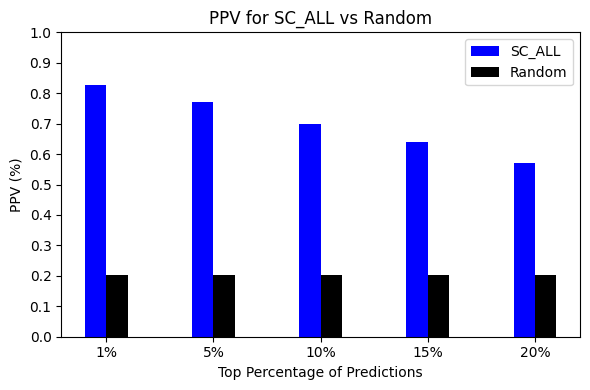

Running classifier SC_GENPROT
--------------------------------------------------
Row data loaded successfully, shape: (4728, 61) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.782608695652174, PPV (5%): 0.6949152542372882
Features: 15, PPV (1%): 0.8260869565217391, PPV (5%): 0.7033898305084746
Features: 14, PPV (1%): 0.9130434782608695, PPV (5%): 0.6694915254237288
Features: 13, PPV (1%): 0.6956521739130435, PPV (5%): 0.6779661016949152
Features: 12, PPV (1%): 0.6956521739130435, PPV (5%): 0.7033898305084746
Features: 11, PPV (1%): 0.8695652173913043, PPV (5%): 0.7033898305084746
Features: 10, PPV (1%): 0.782608695652174, PPV (5%): 0.6610169491525424
Features: 9, PPV (1%): 0.8695652173913043, PPV (5%): 0.6186440677966102
Features: 8, PPV (1%): 0.8260869565217391, PPV (5%): 0.6864406779661016
Features: 7, PPV (1%): 0.8695652173913043, PPV (5%): 0.6949152542372882
Features: 6, PPV (1%): 0.8260869565217391, PPV (5%): 0.694915254237

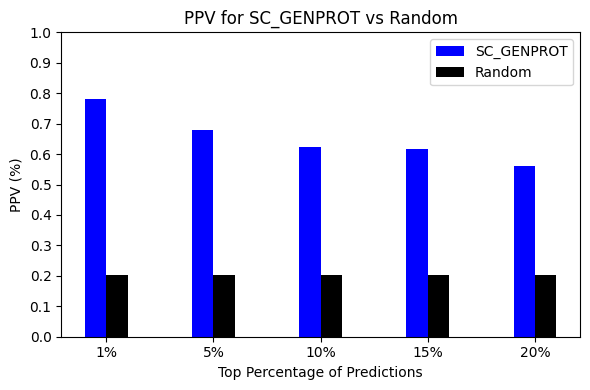

Running classifier SC_NO_GENPROT
--------------------------------------------------
Row data loaded successfully, shape: (4728, 61) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.6521739130434783, PPV (5%): 0.5508474576271186
Features: 14, PPV (1%): 0.6086956521739131, PPV (5%): 0.559322033898305
Features: 13, PPV (1%): 0.5217391304347826, PPV (5%): 0.5084745762711864
Features: 12, PPV (1%): 0.6521739130434783, PPV (5%): 0.5
Features: 11, PPV (1%): 0.6521739130434783, PPV (5%): 0.4915254237288136
Features: 10, PPV (1%): 0.6521739130434783, PPV (5%): 0.4830508474576271
Features: 9, PPV (1%): 0.43478260869565216, PPV (5%): 0.5084745762711864
Features: 8, PPV (1%): 0.6521739130434783, PPV (5%): 0.5508474576271186
Features: 7, PPV (1%): 0.6086956521739131, PPV (5%): 0.4406779661016949
Features: 6, PPV (1%): 0.6521739130434783, PPV (5%): 0.5084745762711864
Features: 5, PPV (1%): 0.6086956521739131, PPV (5%): 0.3898305084745763
Featur

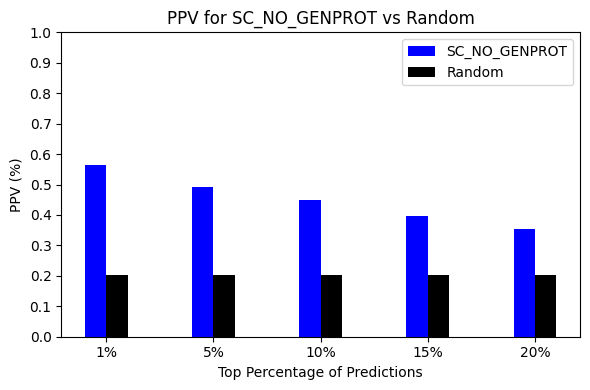

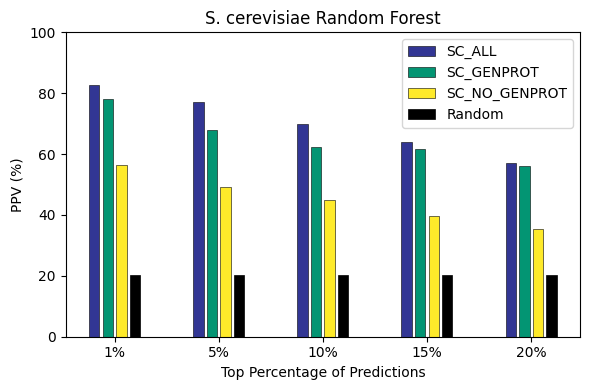

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.83,0.77,0.7,0.64,0.57,24
SC_GENPROT,0.78,0.68,0.62,0.62,0.56,15
SC_NO_GENPROT,0.57,0.49,0.45,0.4,0.35,14


In [17]:


classifier_no_genprot = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae Random Forest", [classifier_all,classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])
experiment.plot_and_save_comparative_table()

